# Basic GP optimizer


**INSTRUCTIONS FOR USE:**
This code will run an offline example as-is without any input arguments. Simply run the file in python.

In order to use it on a specific machine:

- First read 'HOW_TO_USE.txt' and complete steps 1 and 2
   *Note*: It is recommended to make a copy of this file with a unique name and open it so that you don't edit the original.
   
- Then, on line 23 of this file, select the name of your .npy file  (created in step 2 of 'HOW_TO_USE.txt') that contains your desired scan params.

- On line 24, choose if you want results saved by setting saveResultsQ = True/False
    *Note:* If saveResultsQ is set to True, the scan data will be saved to the local directory called 'saved_results' and will have filename formatted as 'scan_YYYY-MM-DD-hhmmss.npy'

- Now choose the condition on which to stop the scan by replacing line 50 with your desired expression


In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from modules.bayes_optimization import BayesOpt, negUCB, negExpImprove
from modules.OnlineGP import OGP
import numpy as np
import importlib
mi_module = importlib.import_module('machine_interfaces.machine_interface_example')

import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

scan_params_filename = 'scan_params_example.npy'#'my_scan_params.npy'
saveResultsQ = False

#load the dict that contains the parameters for the scan (control pv list, starting settings, and gp hyperparams)
scan_params = np.load('params/'+scan_params_filename, allow_pickle=True).item()

#how long to wait between acquisitions
acquisition_delay = scan_params['acquisition_delay']

#create the machine interface
dev_ids = scan_params['dev_ids']
start_point = scan_params['start_point'] #if start_point is set to None, the optimizer will start from the current device settings.
start_point /= 4
mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) #an isotropic n-dimensional gaussian with amplitude=1, centered at the origin, plus gaussian background noise with std dev = 0.1

failed to import parallelstuff


In [2]:
scan_params

{'dev_ids': ['sim_dev_0', 'sim_dev_1', 'sim_dev_2', 'sim_dev_3'],
 'acquisition_delay': 2.0,
 'gp_amp': 2.0,
 'gp_precisionmat': array([[2., 0., 0., 0.],
        [0., 2., 0., 0.],
        [0., 0., 2., 0.],
        [0., 0., 0., 2.]]),
 'start_point': array([0.5, 0.5, 0.5, 0.5]),
 'ucb_params': [2.0, None],
 'gp_noise': 0.2}

In [3]:
#check noise std
y = [mi.getState()[1][0] for x in range(100)]
np.std(y)

0.010851186130963296

**Create the gp**

In [4]:
ndim = len(dev_ids)
gp_precisionmat = scan_params['gp_precisionmat']
gp_amp = scan_params['gp_amp'] 
gp_noise = 0.01#scan_params['gp_noise'] #std
hyps = [gp_precisionmat, np.log(gp_amp), np.log(gp_noise**2)] #format the hyperparams for the OGP
gp = OGP(ndim, hyps)

In [5]:
#create the bayesian optimizer that will use the gp as the model to optimize the machine 
opt = BayesOpt(gp, mi, acq_func="UCB", start_dev_vals = mi.x, dev_ids = dev_ids)
opt.ucb_params = scan_params['ucb_params'] #set the acquisition function parameters
print('ucb_params',opt.ucb_params)

target_func =  <machine_interfaces.machine_interface_example.machine_interface object at 0x7fa47836c550>
********* BO - self.mi = self.target_func wORKED!
Supposed to be grabbing initial machine state...
x_init [[0.5 0.5 0.5 0.5]]
y_init [[0.60804547]]
Using prior mean function of  None
Using prior mean parameters of  None
ucb_params [2.0, None]


**Running BO**

*run the gp search for some number of steps*

In [6]:
Obj_state_s=[]

In [13]:
mi.getState()[1][0]

array([0.60647463])

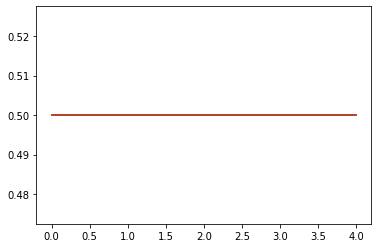

In [15]:
plt.plot(opt.X_obs)

iteration = 49
current position: [[ 0.97564558 -0.52627268  0.058307    0.97439845]] current objective value: [[0.32539511]]


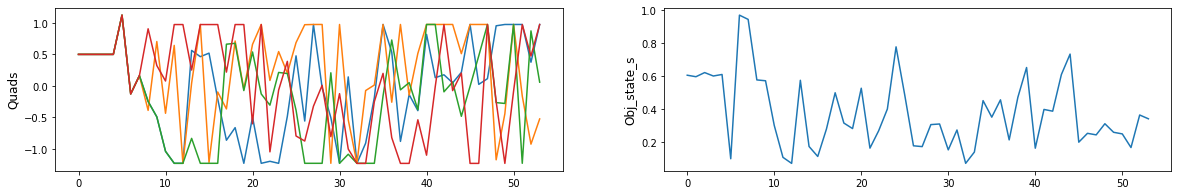

[-0.12799274 -0.12799274 -0.12799274 -0.12923987]
[ 0.97564558  0.4056388  -0.31189848  0.97439845]
[[ 0.97564558  0.4056388  -0.31189848  0.97439845]]


In [16]:
Niter = 50
for i in range(Niter):
    clear_output(wait=True) 
    print ('iteration =', i)
    print ('current position:', mi.x, 'current objective value:', mi.getState()[1])
   
    Obj_state_s.append(mi.getState()[1][0])
    
    f = plt.figure(figsize=(20,3))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax.set_ylabel('Quads',fontsize=12)
    ax.plot(opt.X_obs)
    ax2.set_ylabel('Obj_state_s',fontsize=12)
    ax2.plot(Obj_state_s)
    plt.show(); 
    
    opt.OptIter()
    time.sleep(acquisition_delay)
    time.sleep(0.1)

In [13]:
#save results if desired
if saveResultsQ == True:
    timestr = datetime.now().strftime('%Y-%m-%d-%H%M%S')
    try: os.mkdir('saved_results')
    except: pass
    results = {}
    results['scan_params'] = scan_params
    results['xs'] = opt.X_obs
    results['ys'] = np.array([y[0][0] for y in opt.Y_obs])
    results['time'] = timestr
    np.save('saved_results/scan_'+timestr, results)

In [11]:
import scipy
self = opt
optmethod = 'L-BFGS-B'
maxiter = 1000
tolerance = 1.e-4

In [12]:
(x_best, y_best) = self.best_seen()
self.x_best = x_best
x_curr = self.current_x[-1]
x_start = x_best
ndim = x_curr.size
try:
    nsteps = 1 + self.X_obs.shape[0] # acquisition number we're on  NEEDED FOR UCB
except:
    nsteps = 1

In [13]:

if(self.iter_bound or True):
    if(self.bounds is None): # looks like a scale factor
        self.bounds = 1.0

    bound_lengths = self.searchBoundScaleFactor * 3. * self.lengthscales # 3x hyperparam lengths
    relative_bounds = np.transpose(np.array([-bound_lengths, bound_lengths]))

    #iter_bounds = np.transpose(np.array([x_start - bound_lengths, x_start + bound_lengths]))
    iter_bounds = np.transpose(np.array([x_start - bound_lengths, x_start + bound_lengths]))

else:
    iter_bounds = self.bounds

In [14]:
x_start = [1,1,1,1]

In [15]:
def negUCB(x_new, model, ndim, nsteps, nu = 1., delta = 1.):
    """
    GPUCB: Gaussian process upper confidence bound aquisition function
    Default nu and delta hyperparameters theoretically yield "least regret".
    Works better than "expected improvement" (for alpha==1 above) in 2D.

    input params
    x_new: new point in the dim-dimensional space the GP is fitting
    model: OnlineGP object
    ndim: feature space dimensionality (how many devices are varied)
    nsteps: current step number counting from 1
    nu: nu in the tutorial (see above)
    delta: delta in the tutorial (see above)
    """

    if nsteps==0: nsteps += 1
    (y_mean, y_var) = model.predict(np.array(x_new,ndmin=2))

    if delta is None:
        GPUCB = y_mean + nu * np.sqrt(y_var)
    else:
        tau = 2.*np.log(nsteps**(0.5*ndim+2.)*(np.pi**2.)/3./delta)
        GPUCB = y_mean + np.sqrt(nu * tau * y_var)
    GPUCB = np.squeeze(GPUCB)

    return -GPUCB

In [16]:
res = scipy.optimize.minimize(negUCB, x_start, args=(self.model, 4, 0, 2.0, None), method=optmethod,tol=tolerance,bounds=iter_bounds,options={'maxiter':maxiter})

In [17]:
res

      fun: -2.8929759174036818
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00027569, 0.00027569, 0.00027569, 0.00030957])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 30
      nit: 5
     njev: 6
   status: 0
  success: True
        x: array([1.12501333, 1.12501333, 1.12501333, 1.12499018])

In [26]:
print(self.model.predict(np.array([1,1,1,1],ndmin=2)))

(array([[0.22343679]]), array([[1.72943023]]))


In [19]:
ndim

4